In [ ]:
###Basic Text classification using tf2

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import re

In [3]:
#get data
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')


In [11]:
!ls

In [ ]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'test', 'README', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
directories = os.listdir(train_dir)

In [ ]:
directories

['urls_pos.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'pos',
 'neg',
 'urls_unsup.txt',
 'unsup',
 'unsupBow.feat']

In [ ]:
#look at text file under pos/neg
with open("/content/aclImdb/train/neg/0_3.txt") as f:
  print(f.read())

Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.


In [ ]:
with open("/content/aclImdb/train/pos/0_9.txt") as f:
  print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


###Load dataset

main_directory/ \
...class_a/ \
......a_text_1.txt \
......a_text_2.txt \
...class_b/ \
......b_text_1.txt \
......b_text_2.txt \


To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [ ]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [ ]:
!ls /content/aclImdb/ #

imdbEr.txt  imdb.vocab	README	test  train


In [ ]:
#use text_dataset_from_directory util to create a labeled tf.data.Dataset
batch_size = 42
seed = 42

raw_train_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
# .8*25000 #confirming the split

20000.0

In [ ]:
for text_batch, label_batch in raw_train_dataset.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"Rob Estes, Josie Bisset and a crap load of kids that look nothing like either of them.<br /><br />Basically, Rob and Josie have a shotgun wedding on a drunken night during a Vegas vacation. They each come home to find that their respective children already know of the nuptials due to tabloid-like not-so-fodder. They, Rob and Josie, move both of them and their eight kids into one or the other's house.<br /><br />Rob builds furniture, I think, which is close enough to Frank Lambert's (Patrick Duffy) construction job on the much similar Step by Step to warrant eternal mockage.<br /><br />Josie is some sort of cookie-making queen, though it doesn't look like she makes any of the cookies. Not close enough to Carol Foster's (Suzanne Somers)hairdressing job to warrant likeness mockage, but hilariously preposterous enough to warrant atrocity mockage.<br /><br />Unlike Step by Step, they were a couple before the vacation and actually knew one another's last names, or so one assumes if 

In [ ]:
print("Label 0 ->", raw_train_dataset.class_names[0])
print("Label 1 ->", raw_train_dataset.class_names[1])

Label 0 -> neg
Label 1 -> pos


In [ ]:
raw_val_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train", 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.


Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

**Note:** to prevent train/test skew (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the TextVectorization layer can be included directly inside your model, as shown later in this tutorial.

In [ ]:
#prepare dataset for training
import string

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(
      stripped_html,
      "[%s]" % re.escape(string.punctuation),
      ""
  )

Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

**Note** that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
    )


Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [ ]:
train_text = raw_train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
#function to see the result of using the above layer to 
#preprocess some data.

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_dataset.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"Live Feed is set in some unnamed Chinese/Japanese Asian district somewhere as five American friends, Sarah (Ashley Schappert), Emily (Taayla Markell), Linda (Caroline Chojnacki), Mike (Lee Tichon) & Darren (Rob Scattergood) are enjoying a night on the town & taking in the sights. After a scuffle in a bar with a Japanese Triad boss (Stephen Chang) they decide to check out a porno theatre, as you would. Inside they are separated & quickly find out that the place belongs to the Triad boss who uses it to torture & kill people for reasons which aren't made clear. Can local boy Miles (Kevan Ohtsji) save them?<br /><br />This Canadian production was co-written, produced & directed by Ryan Nicholson who also gets a prosthetic effects designer credit as well, one has to say that Live Feed is another pretty poor low budget shot on a camcorder type horror film that seems to exist only to cash in on the notoriety & success of Hostel (2005) & the mini craze for 'torture porn' as 

In [ ]:
print("879---> ",vectorize_layer.get_vocabulary()[879])
print(" 1729 ---> ",vectorize_layer.get_vocabulary()[1729])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

879--->  meets
 1729 --->  physical
Vocabulary size: 10000


In [ ]:
train_dataset = raw_train_dataset.map(vectorize_text)
val_dataset = raw_val_dataset.map(vectorize_text)
test_dataset = raw_test_dataset.map(vectorize_text)

###Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
#create the model
embedding_dim = 16

In [ ]:
"""
    The first layer is an Embedding layer. 
    This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the word embedding tutorial.
    
    Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
    
    This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
    
    The last layer is densely connected with a single output node.
"""
imdb_model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features+1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
#get summary
imdb_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=0
)

In [ ]:
#compile
imdb_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

epochs = 10

#fit/train
training_history = imdb_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[callback])

Epoch 1/10
477/477 [==============================] - 3s 6ms/step - loss: 0.5948 - accuracy: 0.7824 - val_loss: 0.5590 - val_accuracy: 0.7974


In [ ]:
#evaluate the model
loss, acc = imdb_model.evaluate(test_dataset, verbose=2)

596/596 - 1s - loss: 0.5626 - accuracy: 0.7889


In [ ]:
#plot loss curves
metrics_list = pd.DataFrame(training_history.history)
metrics_list

,loss,accuracy,val_loss,val_accuracy
0,0.594845,0.78235,0.558975,0.7974


In [ ]:
loss = metrics_list["loss"]
acc = metrics_list["binary_accuracy"]
val_loss = metrics_list["val_loss"]
val_acc = metrics_list["val_binary_accuracy"]

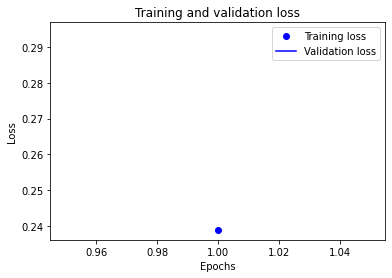

In [ ]:
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

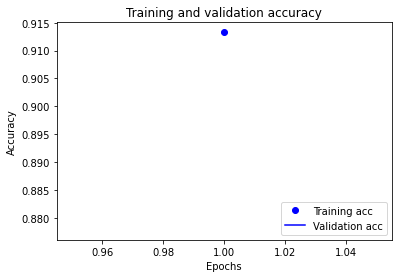

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()